In [15]:
import gymnasium as gym
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
## Utils

def get_action(training, env, rng, q_table, state_position, state_velocity, epsilon):
    if rng.random() < epsilon and training:
            return env.action_space.sample()
    else:
        return np.argmax(q_table[state_position, state_velocity, :])
    
def get_q_table():
    return pkl.load(open('q.pkl', 'rb'))


def run_simulation(training, q_table = None):
    ### Parameters

    # env parameters
    env_name = 'MountainCar-v0'
    render_mode = None if training else 'human'

    # Q-learning parameters
    max_steps = 2000
    num_states = 25
    num_episodes = 5000
    learning_rate = 0.9
    discount_factor = 0.9

    min_epsilon = 0
    epsilon = 1
    epsilon_decay = 2 / num_episodes
    rng = np.random.default_rng()

    ### Environment
    env = gym.make(env_name, render_mode=render_mode)
    rewards_per_episode = np.zeros(num_episodes)

    ### Discretize the state space
    position_space = np.linspace(env.observation_space.low[0], env.observation_space.high[0], num_states)
    velocity_space = np.linspace(env.observation_space.low[1], env.observation_space.high[1], num_states)

    ### Q-table
    if q_table is None or training:
        q_table = np.zeros((num_states, num_states, env.action_space.n))

        
        
    for i in range(num_episodes):
        # Init env variables
        state = env.reset()[0]
        state_position = np.digitize(state[0], position_space) 
        state_velocity = np.digitize(state[1], velocity_space)
        terminated = False
        rewards = 0

        step = 1
        ### Q-learning and simulation
        while not terminated and rewards > - max_steps:
            action = get_action(training, env, rng, q_table, state_position, state_velocity, epsilon)
            
            observation, reward, terminated, truncated, info = env.step(action)
            
            new_state_position = np.digitize(state[0], position_space)
            new_state_velocity = np.digitize(state[1], velocity_space)
            
            if training:
                q_table[state_position, state_velocity, action] = q_table[state_position, state_velocity, action] + learning_rate * (reward + discount_factor * np.max(q_table[new_state_position, new_state_velocity, :]) - q_table[state_position, state_velocity, action])
            
            state_position, state_velocity = new_state_position, new_state_velocity
            state = observation
            rewards += reward
            step += 1
            
        epsilon = max(epsilon - epsilon_decay, min_epsilon)
        if not training:
            break
        rewards_per_episode[i] = rewards
    env.close()
    if(training):
        pkl.dump(q_table, open('q.pkl', 'wb'))
        visualize_rewards(num_episodes, rewards_per_episode)
    
def visualize_rewards(num_episodes, rewards_per_episode):
    mean_rewards = np.zeros(num_episodes)
    for t in range(num_episodes):
        mean_rewards[t] = np.mean(rewards_per_episode[max(0, t-100):(t+1)])
    plt.figure()
    plt.title('Learning curve')
    plt.xlabel('Episodes')
    plt.ylabel('Mean reward')
    plt.plot(mean_rewards)

### Training

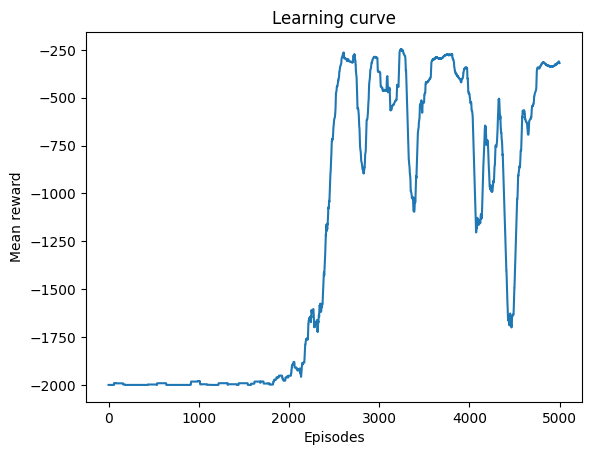

In [16]:
run_simulation(True)

### Visualize results

In [17]:
q = get_q_table()
run_simulation(False, q)
